#### MetaData - Prepared manually by taking the Fitness -https://royalsocietypublishing.org/doi/10.1098/rspb.2015.2292 & the allele count data and sequencing data - https://github.com/benjaminhgood/LTEE-metagenomic.

##### import libary

In [1]:
import sys
sys.path.append("../..")
sys.path.append("../../..")

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu, fisher_exact
import utility, importlib
from scipy.stats import spearmanr
import pingouin as pg
from scipy.stats import linregress
import warnings
import seaborn as sns
import utility
warnings.filterwarnings('ignore', category=pd.errors.PerformanceWarning)
pd.set_option('mode.chained_assignment', None)

##### Read gain sheet data

In [3]:
df_Gain_calculated = pd.read_excel("../../../data/MetaData_ecoli_final.xlsx", sheet_name= "Gain score")
df_Gain_calculated.head()

,Position,Gene,Allele,Ref_allele,Alt_allele,Annotation,label,accumulated_gain
0,63,intergenic,A->C,A,C,noncoding,p6,-10.385914
1,201,thrL,T->G,T,G,missense,p6,-1.750693
2,241,thrL,A->C,A,C,missense,m1,-0.911836
3,309,thrA,T->G,T,G,noncoding,m1,4.009052
4,322,thrA,A->G,A,G,noncoding,p3,1.532477


In [4]:
df_Gain_calculated[df_Gain_calculated.duplicated(subset=['Position', 'Gene',
 'Allele', 'Annotation', 'Ref_allele', 'Alt_allele','label'])]

,Position,Gene,Allele,Ref_allele,Alt_allele,Annotation,label,accumulated_gain


##### Read Allele count and generation data from metasheet

In [5]:
df_Alt_allele_count_all_generation = pd.read_excel("../../../data/MetaData_ecoli_final.xlsx", sheet_name= "Mastersheet")
df_Alt_allele_count_all_generation.head()

,CHROM,Position,Gene,Allele,Annotation,AC:0,AC:1000,AC:1500,AC:2000,AC:2500,...,AC:57000,AC:57500,AC:58000,AC:58500,AC:59000,AC:59500,AC:60000,Ref_allele,Alt_allele,label
0,chrI,1554,thrA,C->A,missense,0,1,0,2,1.0,...,0,0,1.0,0.0,1.0,0.0,0.0,C,A,p1
1,chrI,1556,thrA,C->A,synonymous,0,0,0,2,0.0,...,0,0,0.0,0.0,0.0,0.0,0.0,C,A,p1
2,chrI,2450,thrA,G->T,synonymous,0,0,0,0,0.0,...,81,41,109.0,129.0,4.0,67.0,8.0,G,T,p1
3,chrI,4274,thrC,C->T,missense,0,0,0,0,0.0,...,0,0,0.0,0.0,0.0,0.0,0.0,C,T,p1
4,chrI,6400,yaaA,T->G,missense,0,0,0,0,2.0,...,0,0,0.0,0.0,0.0,0.0,0.0,T,G,p1


##### Check if any duplicated row

In [6]:
df_Alt_allele_count_all_generation[df_Alt_allele_count_all_generation.duplicated(subset=['Position', 'Gene', 'Allele', 'Annotation', 'Ref_allele', 'Alt_allele','label'])]

,CHROM,Position,Gene,Allele,Annotation,AC:0,AC:1000,AC:1500,AC:2000,AC:2500,...,AC:57000,AC:57500,AC:58000,AC:58500,AC:59000,AC:59500,AC:60000,Ref_allele,Alt_allele,label
2028,chrI,450000,ylaB,A->G,missense,0,0,0,0,0.0,...,0,0,0.0,0.0,0.0,0.0,0.0,A,G,p3


##### delete duplicate row in df_Alt_allele_count_all_generation dataframe where duplicate indicate when ['CHROM','Position', 'Gene', 'Allele', 'Annotation', 'Ref_allele', 'Alt_allele','label'] are same in mutiple row


In [7]:
df_Alt_allele_count_all_generation.drop_duplicates(subset=['CHROM','Position', 'Gene', 'Allele', 'Annotation', 'Ref_allele', 'Alt_allele','label'], inplace=True)
df_Alt_allele_count_all_generation.reset_index(inplace=True, drop=True)
# df_Alt_allele_count_all_generation

In [8]:
df_Alt_allele_count_all_generation.head()

,CHROM,Position,Gene,Allele,Annotation,AC:0,AC:1000,AC:1500,AC:2000,AC:2500,...,AC:57000,AC:57500,AC:58000,AC:58500,AC:59000,AC:59500,AC:60000,Ref_allele,Alt_allele,label
0,chrI,1554,thrA,C->A,missense,0,1,0,2,1.0,...,0,0,1.0,0.0,1.0,0.0,0.0,C,A,p1
1,chrI,1556,thrA,C->A,synonymous,0,0,0,2,0.0,...,0,0,0.0,0.0,0.0,0.0,0.0,C,A,p1
2,chrI,2450,thrA,G->T,synonymous,0,0,0,0,0.0,...,81,41,109.0,129.0,4.0,67.0,8.0,G,T,p1
3,chrI,4274,thrC,C->T,missense,0,0,0,0,0.0,...,0,0,0.0,0.0,0.0,0.0,0.0,C,T,p1
4,chrI,6400,yaaA,T->G,missense,0,0,0,0,2.0,...,0,0,0.0,0.0,0.0,0.0,0.0,T,G,p1


##### Read LLR Score

In [9]:
df_esm = pd.read_excel("../../../data/LLR.xlsx")
df_esm.head()

,Position,Gene,Allele,Ref_allele,Alt_allele,Annotation,label,Start,End,Strand,...,has_space,WT_aa_made2,comparison2,Mut_aa_made,SNP,seq_id_x,universal_id,seq_id_y,mut_name,esm_score
0,241,thrL,A->C,A,C,missense,m1,190,255,+,...,False,MKRISTTITTTITITTGNGAG,True,MKRISTTITTTITITTGHGAG,N18H,241_thrL,241_thrL_N18H,241_thrL,N18H,-4.279933
1,1615,thrA,T->G,T,G,missense,m1,336,2798,+,...,False,MRVLKFGGTSVANAERFLRVADILESNARQGQVATVLSAPAKITNH...,True,MRVLKFGGTSVANAERFLRVADILESNARQGQVATVLSAPAKITNH...,I427S,1615_thrA,1615_thrA_I427S,1615_thrA,I427S,-11.530375
2,8430,talB,T->G,T,G,missense,m1,8236,9189,+,...,False,MTDKLTSLRQYTTVVADTGDIAAMKLYQPQDATTNPSLILNAAQIP...,True,MTDKLTSLRQYTTVVADTGDIAAMKLYQPQDATTNPSLILNAAQIP...,D65E,8430_talB,8430_talB_D65E,8430_talB,D65E,-5.331029
3,12527,dnaK,A->C,A,C,missense,m1,12161,14077,+,...,False,MGKIIGIDLGTTNSCVAIMDGTTPRVLENAEGDRTTPSIIAYTQDG...,True,MGKIIGIDLGTTNSCVAIMDGTTPRVLENAEGDRTTPSIIAYTQDG...,M123L,12527_dnaK,12527_dnaK_M123L,12527_dnaK,M123L,-4.669276
4,13974,dnaK,A->C,A,C,missense,m1,12161,14077,+,...,False,MGKIIGIDLGTTNSCVAIMDGTTPRVLENAEGDRTTPSIIAYTQDG...,True,MGKIIGIDLGTTNSCVAIMDGTTPRVLENAEGDRTTPSIIAYTQDG...,Q605P,13974_dnaK,13974_dnaK_Q605P,13974_dnaK,Q605P,-7.992450


##### Drop Duplicates if any in df_esm

In [10]:
df_esm_no_duplicates = df_esm[["Position",  "Gene", "label", "esm_score", "Allele"]].drop_duplicates(subset= ["Position",  "Gene", "label", "Allele"], keep='first')
df_esm_no_duplicates.dropna(inplace=True)
df_esm_no_duplicates.reset_index(inplace=True, drop=True)
df_esm_no_duplicates.head()

,Position,Gene,label,esm_score,Allele
0,241,thrL,m1,-4.279933,A->C
1,1615,thrA,m1,-11.530375,T->G
2,8430,talB,m1,-5.331029,T->G
3,12527,dnaK,m1,-4.669276,A->C
4,13974,dnaK,m1,-7.992450,A->C


##### Merge Gain score and allele count

In [11]:
df_complete = pd.merge(df_Gain_calculated,df_Alt_allele_count_all_generation, on=['Position','Gene','Allele','Annotation','Ref_allele','Alt_allele','label'], how = "left")
df_complete.head()

,Position,Gene,Allele,Ref_allele,Alt_allele,Annotation,label,accumulated_gain,CHROM,AC:0,...,AC:55500,AC:56000,AC:56500,AC:57000,AC:57500,AC:58000,AC:58500,AC:59000,AC:59500,AC:60000
0,63,intergenic,A->C,A,C,noncoding,p6,-10.385914,chrI,0,...,49,78,45,22,36,39.0,11.0,1.0,1.0,6.0
1,201,thrL,T->G,T,G,missense,p6,-1.750693,chrI,0,...,100,140,93,28,79,62.0,15.0,3.0,0.0,13.0
2,241,thrL,A->C,A,C,missense,m1,-0.911836,chrI,0,...,6,1,2,0,0,0.0,0.0,0.0,0.0,0.0
3,309,thrA,T->G,T,G,noncoding,m1,4.009052,chrI,0,...,0,0,0,0,0,0.0,1.0,2.0,7.0,9.0
4,322,thrA,A->G,A,G,noncoding,p3,1.532477,chrI,0,...,23,24,13,16,26,8.0,30.0,22.0,23.0,0.0


##### Extract the column relavent for current analysis from allele count dataframe (all the generation wise allele count, 'CHROM','Position', 'Gene', 'Allele', 'Annotation', 'Ref_allele', 'Alt_allele','label')


In [12]:
filtered_list = [item for item in df_complete if item.startswith("AC")] ## Fiter the column starting with "AC" which indicate allele count
filtered_list.extend(['CHROM','Position', 'Gene', 'Allele', 'Annotation', 'Ref_allele', 'Alt_allele','label', "accumulated_gain"]) ##Add other relavent information
df_allele_generation = df_complete[filtered_list]
df_allele_generation.head() # Get complete dataframe containing all generation wise allele count and other relavent column

,AC:0,AC:1000,AC:1500,AC:2000,AC:2500,AC:3000,AC:4000,AC:4500,AC:5000,AC:5500,...,AC:60000,CHROM,Position,Gene,Allele,Annotation,Ref_allele,Alt_allele,label,accumulated_gain
0,0,0,0,0,0.0,0,0,0,0,0,...,6.0,chrI,63,intergenic,A->C,noncoding,A,C,p6,-10.385914
1,0,0,0,0,0.0,0,0,0,0,0,...,13.0,chrI,201,thrL,T->G,missense,T,G,p6,-1.750693
2,0,0,0,0,0.0,0,0,0,0,0,...,0.0,chrI,241,thrL,A->C,missense,A,C,m1,-0.911836
3,0,0,0,0,0.0,0,0,0,0,0,...,9.0,chrI,309,thrA,T->G,noncoding,T,G,m1,4.009052
4,0,0,0,0,0.0,0,0,0,0,0,...,0.0,chrI,322,thrA,A->G,noncoding,A,G,p3,1.532477


##### Define mutator and non-mutator population 

In [13]:
mutator_list = ['m1', 'm2', 'm3', 'm4', 'p3', 'p6']
non_mutator_list = ['p1', 'p2', 'p4', 'p5', 'm5', 'm6']

##### Find the generation which have missing value 

In [14]:
nan_columns = df_allele_generation.columns[df_allele_generation.isna().any()]
df_with_nan = df_allele_generation[nan_columns]
nan_counts = df_allele_generation.isna().sum()
nan_counts = nan_counts[nan_counts > 0]
print("\n Number of NaN values in each column:")
print(nan_counts)


 Number of NaN values in each column:
AC:2500      355
AC:15000    4953
AC:46500     331
AC:58000    3753
AC:58500     355
AC:59000     355
AC:59500     355
AC:60000     355
dtype: int64


##### Drop the generation having nan values

In [15]:
df_allele_generation.drop(nan_counts.index.tolist(), axis = 1, inplace=True)
df_allele_generation.reset_index(inplace=True, drop = True)
df_allele_generation.head()

,AC:0,AC:1000,AC:1500,AC:2000,AC:3000,AC:4000,AC:4500,AC:5000,AC:5500,AC:6000,...,AC:57500,CHROM,Position,Gene,Allele,Annotation,Ref_allele,Alt_allele,label,accumulated_gain
0,0,0,0,0,0,0,0,0,0,0,...,36,chrI,63,intergenic,A->C,noncoding,A,C,p6,-10.385914
1,0,0,0,0,0,0,0,0,0,0,...,79,chrI,201,thrL,T->G,missense,T,G,p6,-1.750693
2,0,0,0,0,0,0,0,0,0,0,...,0,chrI,241,thrL,A->C,missense,A,C,m1,-0.911836
3,0,0,0,0,0,0,0,0,0,0,...,0,chrI,309,thrA,T->G,noncoding,T,G,m1,4.009052
4,0,0,0,0,0,0,0,0,0,0,...,26,chrI,322,thrA,A->G,noncoding,A,G,p3,1.532477


In [16]:
# # Get the columns that start with 'AC'
# ac_columns = [col for col in df_allele_generation.columns if col.startswith('AC')]
# # Sum the columns column-wise
# df_allele_generation["sum of alt AC"] =  df_allele_generation[ac_columns].sum(axis=1)
# df_allele_generation["number_of_mutations"] = (df_allele_generation[ac_columns] != 0).sum(axis=1)
# df_allele_generation["mutation type"] = np.where(df_allele_generation[ 'number_of_mutations'] > df_allele_generation["number_of_mutations"].median(), "Carry forward", "non carry forward") 
# ##### Where number_of_mutations> median number of mutations, assign it Carry forward otherwise assign non carry forward

In [17]:
# aaaaa

##### Create dataset having all mutation info in proper form for easy calculation
##### Make a dataframe having column ['label', 'CHROM', 'Position', 'Gene', 'Allele', 'Annotation', 'generation', 'allele count', 'generation_number']

In [18]:
data_all_copy = df_allele_generation.copy()
all_mutation = pd.DataFrame() # The all_mutation dataframe contain generation and population wise accumulated gain

for i in data_all_copy.columns[:-9]:
    new_df_tmp = pd.DataFrame()
    new_df = data_all_copy[data_all_copy.loc[:, i]!=0]
    new_df_tmp = new_df[["label", 'CHROM', 'Position', 'Gene', 'Allele', 'Annotation']]
    new_df_tmp.loc[:, "generation"] = i
    new_df_tmp.loc[:, "AG"] = new_df.loc[:, "accumulated_gain"]
    new_df_tmp.loc[:, "allele count"] = new_df.loc[:, i]
    all_mutation = pd.concat([all_mutation, new_df_tmp], axis = 0)
    
    
all_mutation.reset_index(inplace=True, drop=True)
all_mutation['generation_number'] = all_mutation['generation'].str.extract(r'(\d+)').astype(int)
for i in range(all_mutation.shape[0]):
    
    if all_mutation.loc[i, "label"] in mutator_list:
        all_mutation.loc[i, "mutator"] = "mutator"
    if all_mutation.loc[i, "label"] in non_mutator_list:
        all_mutation.loc[i, "mutator"] = "non mutator"

all_mutation.head()

,label,CHROM,Position,Gene,Allele,Annotation,generation,AG,allele count,generation_number,mutator
0,m6,chrI,1457,thrA,G->A,missense,AC:0,-8.160701,1,0,non mutator
1,m2,chrI,2098,thrA,A->G,missense,AC:0,0.007780,1,0,mutator
2,m2,chrI,2942,thrB,A->G,missense,AC:0,-4.953477,1,0,mutator
3,m4,chrI,5437,yaaX,A->G,missense,AC:0,-10.279634,1,0,mutator
4,m5,chrI,7129,yaaJ,A->C,missense,AC:0,2.182288,2,0,non mutator


##### Remove white spaces from columns

In [19]:
df_esm_no_duplicates["Gene"] = df_esm_no_duplicates["Gene"].str.strip()
all_mutation["Gene"] = all_mutation["Gene"].str.strip()
df_esm_no_duplicates["Allele"] = df_esm_no_duplicates["Allele"].str.strip()
all_mutation["Allele"] = all_mutation["Allele"].str.strip()

In [20]:
# df_esm_no_duplicates

##### Merge LLR score with Allele count

In [21]:
all_mutation_with_esm_1b_score = pd.merge(all_mutation, df_esm_no_duplicates, on = ["label", 'Position', "Gene", 'Allele'], how="left")
all_mutation_with_esm_1b_score_drop_na = all_mutation_with_esm_1b_score.dropna(subset=["esm_score"])    ##### drop the row where esm score is not available
all_mutation_with_esm_1b_score_drop_na.reset_index(inplace=True, drop=True)
all_mutation_with_esm_1b_score_drop_na.head()

,label,CHROM,Position,Gene,Allele,Annotation,generation,AG,allele count,generation_number,mutator,esm_score
0,m6,chrI,1457,thrA,G->A,missense,AC:0,-8.160701,1,0,non mutator,-3.043034
1,m2,chrI,2098,thrA,A->G,missense,AC:0,0.007780,1,0,mutator,-9.017883
2,m2,chrI,2942,thrB,A->G,missense,AC:0,-4.953477,1,0,mutator,-2.160521
3,m4,chrI,5437,yaaX,A->G,missense,AC:0,-10.279634,1,0,mutator,-3.740739
4,m5,chrI,7129,yaaJ,A->C,missense,AC:0,2.182288,2,0,non mutator,-6.933856


In [22]:
"population_label"

'population_label'

##### Plot accumulated gain vs type of mutator against essential and non essential gene

In [23]:
df_essential_gene = pd.read_excel("../../../data/gene type.xlsx")
df_essential_gene.head()

,Gene,type
0,thrL,non-essential
1,thrA,non-essential
2,thrB,non-essential
3,thrC,non-essential
4,yaaX,non-essential


##### drop row where gene name is not available

In [24]:
df_essential_gene.dropna(subset=["Gene"], inplace=True)
df_essential_gene.reset_index(inplace=True, drop=True)
df_essential_gene["Gene"] = df_essential_gene["Gene"].str.strip() # Trim white spaces from "Gene" column
df_essential_gene.head()

,Gene,type
0,thrL,non-essential
1,thrA,non-essential
2,thrB,non-essential
3,thrC,non-essential
4,yaaX,non-essential


In [25]:
all_mutation_with_esm_1b_score_drop_na =  pd.merge(all_mutation_with_esm_1b_score_drop_na, df_essential_gene, on = ["Gene"])

In [26]:
# Get the columns that start with 'AC'
ac_columns = [col for col in df_allele_generation.columns if col.startswith('AC')]

# Sum the columns column-wise
df_allele_generation["sum of alt AC"] =  df_allele_generation[ac_columns].sum(axis=1)

df_allele_generation["Gene"] = df_allele_generation["Gene"].str.strip()
df_allele_generation["Allele"] = df_allele_generation["Allele"].str.strip()

df_allele_generation["number_of_mutations"] = (df_allele_generation[ac_columns] != 0).sum(axis=1)
df_allele_generation["mutation type"] = np.where(df_allele_generation[ 'number_of_mutations'] > df_allele_generation["number_of_mutations"].median(), "Carry forward", "non carry forward") 

In [27]:
# all_mutation_with_esm_1b_score_drop_na

In [28]:
# Get the columns that start with 'AC'
ac_columns = [col for col in df_allele_generation.columns if col.startswith('AC')]

# Sum the columns column-wise
df_allele_generation["sum of alt AC"] =  df_allele_generation[ac_columns].sum(axis=1)

df_allele_generation["Gene"] = df_allele_generation["Gene"].str.strip()
df_allele_generation["Allele"] = df_allele_generation["Allele"].str.strip()

df_allele_generation["number_of_mutations"] = (df_allele_generation[ac_columns] != 0).sum(axis=1)
df_allele_generation["mutation type"] = np.where(df_allele_generation[ 'number_of_mutations'] > df_allele_generation["number_of_mutations"].median(), "Carry forward", "non carry forward") 

In [29]:
# df_gene_type_llr_unique_mutation = all_mutation_with_esm_1b_score_drop_na.drop_duplicates(subset = ['label', 'CHROM', 'Position', 'Gene', 'Allele'])

df_gene_type_llr_mutation = pd.merge(all_mutation_with_esm_1b_score_drop_na, df_allele_generation[["Gene", "Position", "label", "CHROM", "Allele", "mutation type"]].drop_duplicates(), on = ["Gene", "Position", "label", "CHROM", "Allele"])

In [30]:
df_gene_type_llr_mutation

,label,CHROM,Position,Gene,Allele,Annotation,generation,AG,allele count,generation_number,mutator,esm_score,type,mutation type
0,m6,chrI,1457,thrA,G->A,missense,AC:0,-8.160701,1,0,non mutator,-3.043034,non-essential,non carry forward
1,m2,chrI,2098,thrA,A->G,missense,AC:0,0.007780,1,0,mutator,-9.017883,non-essential,Carry forward
2,m2,chrI,2942,thrB,A->G,missense,AC:0,-4.953477,1,0,mutator,-2.160521,non-essential,Carry forward
3,m4,chrI,5437,yaaX,A->G,missense,AC:0,-10.279634,1,0,mutator,-3.740739,non-essential,non carry forward
4,m5,chrI,7129,yaaJ,A->C,missense,AC:0,2.182288,2,0,non mutator,-6.933856,non-essential,Carry forward
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
468908,p6,chrI,4628381,arcA,T->G,missense,AC:57500,-1.042442,52,57500,mutator,-3.082379,non-essential,Carry forward
468909,p1,chrI,4628460,arcA,T->G,missense,AC:57500,-1.331908,46,57500,non mutator,-5.029455,non-essential,Carry forward
468910,m3,chrI,4629225,lasT,C->T,missense,AC:57500,-5.614587,72,57500,mutator,-3.614679,non-essential,Carry forward
468911,m2,chrI,4629441,lasT,C->T,missense,AC:57500,-8.417367,4,57500,mutator,-6.809723,non-essential,Carry forward


##### fig 3a. LLR vs  mutator type

P-value = 3.86e-01 and effect size = 1.16e-01 for non mutator,
P-value = 5.06e-01 and effect size = -7.70e-02 for mutator,


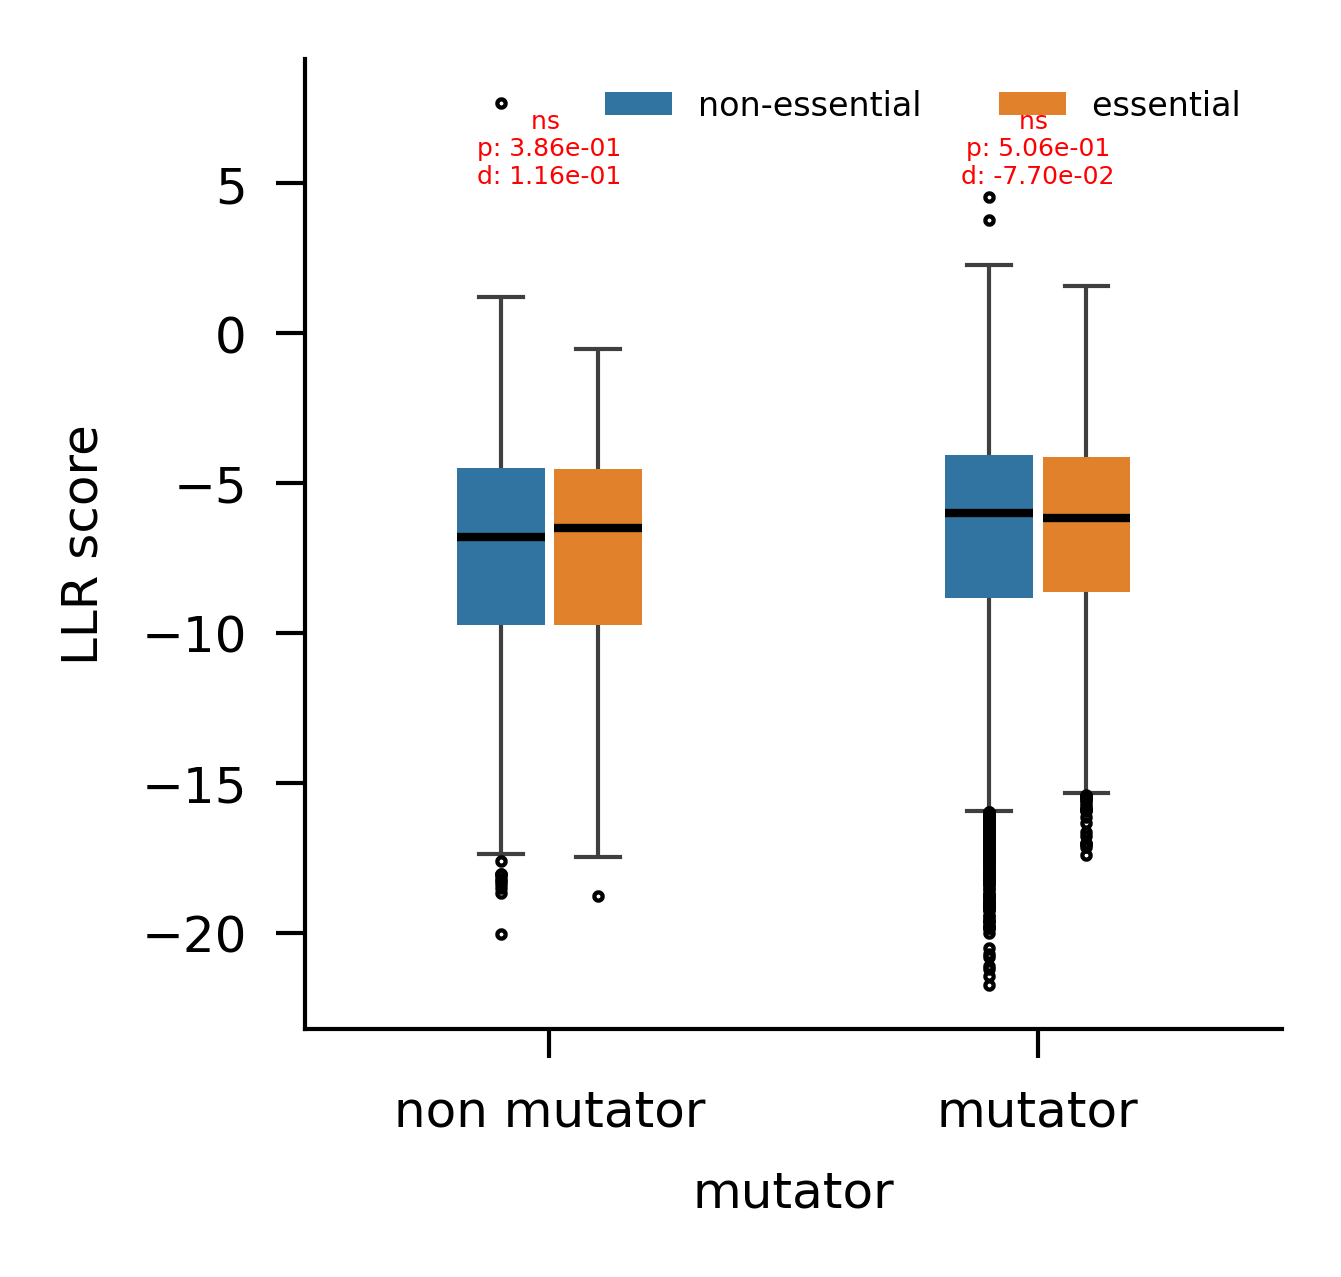

In [ ]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

fig, ax = plt.subplots(1, 1, dpi = 600, figsize = (2.1, 2.1), sharex=True)
data = df_gene_type_llr_mutation.drop_duplicates(subset=['label', 'CHROM', 'Position', 'Gene', 'Allele', "label"])
ax= sns.boxplot(data=data,
                 y = "esm_score", x = "mutator", hue ="type", boxprops=dict(edgecolor="black", linewidth=0),ax=ax,flierprops=dict(marker='o', markeredgecolor='black', markersize=0.5), width=0.4,linewidth=0.5, fliersize=0.15, dodge=True, medianprops={"color": "black","linewidth":1}, gap = 0.1)
ax= utility.custom_figure_axis(ax, fontsize=6, show_ticks = True, rotation=0)
ax.set_ylabel("LLR score")
ax.legend(ncol=2, fontsize = 4, frameon=False)
ax = utility.return_box_with_p_effect_size(ax, data = data, x_columns = 'mutator', y_columns = 'esm_score', group1_name = 'essential ', group2_name = 'non-essential ', y_pos = 5, hue_columns="type", fontsize=3)
plt.savefig("Mutator type wise LLR with gene essentiality.pdf", dpi = 300)

In [49]:
# df_gene_type_llr_mutation

P-value = 7.22e-02 and effect size = 8.03e-02 for non mutator,
P-value = 1.00e+00 and effect size = -9.27e-02 for mutator,


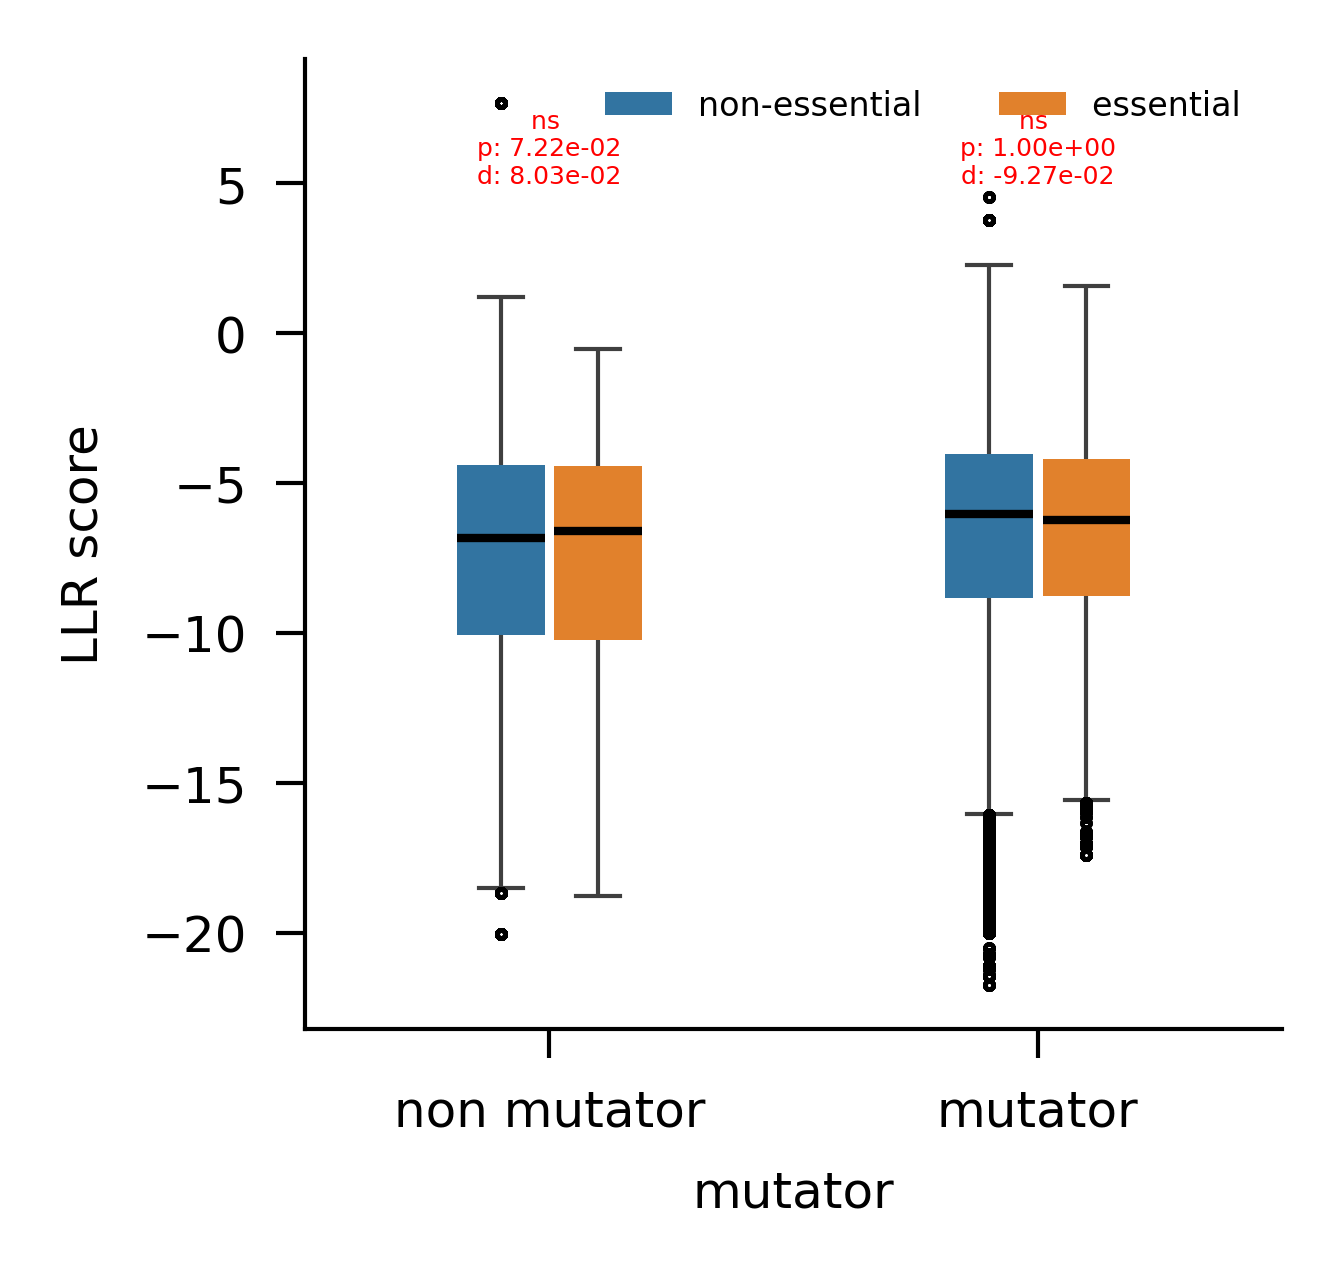

In [33]:
# sns.reset_defaults()
fig, ax = plt.subplots(1, 1, dpi = 600, figsize = (2.1, 2.1), sharex=True)

ax= sns.boxplot(data=df_gene_type_llr_mutation, y = "esm_score", x = "mutator", hue ="type", boxprops=dict(edgecolor="black", linewidth=0),ax=ax,flierprops=dict(marker='o', markeredgecolor='black', markersize=0.5), width=0.4,linewidth=0.5, fliersize=0.15, dodge=True, medianprops={"color": "black","linewidth":1}, gap = 0.1)
ax= utility.custom_figure_axis(ax, fontsize=6, show_ticks = True, rotation=0)
ax.set_ylabel("LLR score")
ax.legend(ncol=2, fontsize = 4, frameon=False)
ax = utility.return_box_with_p_effect_size(ax, data = df_gene_type_llr_mutation, x_columns = 'mutator', y_columns = 'esm_score', group1_name = 'essential ', group2_name = 'non-essential ', y_pos = 5, hue_columns="type", fontsize=3)


##### fig S3.b, c : The generation wise median LLR (Mutator and non mutator)

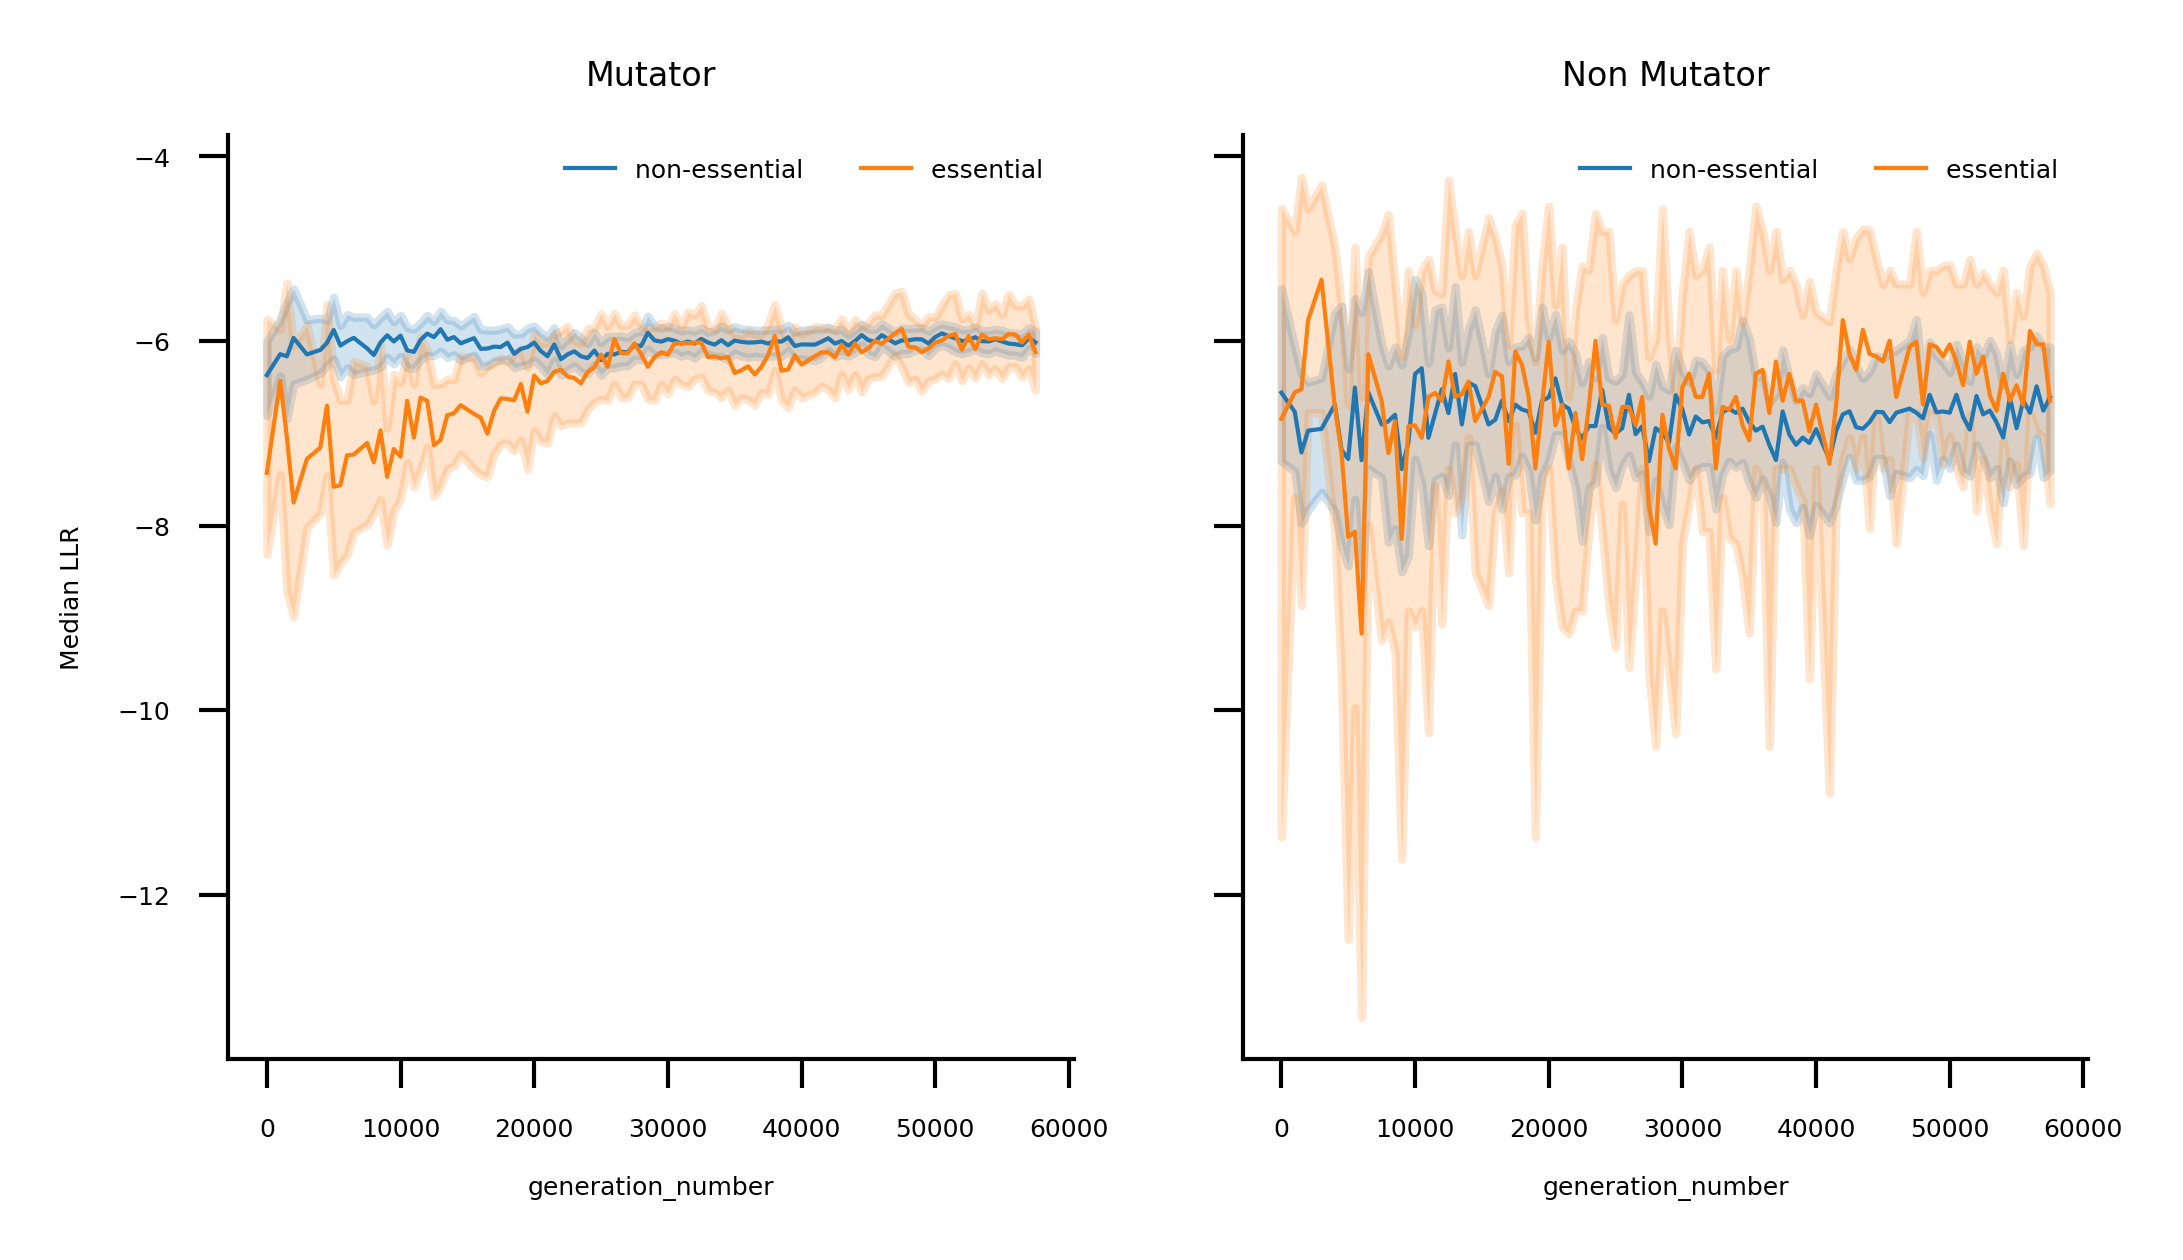

In [34]:
fig, ax = plt.subplots(1, 2, sharey=True, sharex=True, dpi = 600, figsize=(4,2))
ax[0] = sns.lineplot(all_mutation_with_esm_1b_score_drop_na[all_mutation_with_esm_1b_score_drop_na["mutator"].isin(["mutator"])], hue="type", x = "generation_number", y = "esm_score", lw=0.5, estimator="median", ax=ax[0])
ax[1] = sns.lineplot(all_mutation_with_esm_1b_score_drop_na[all_mutation_with_esm_1b_score_drop_na["mutator"].isin(["non mutator"])], hue="type", x = "generation_number", y = "esm_score", lw=0.5, estimator="median", ax=ax[1])

ax[0].set_title("Mutator", fontsize=4)
ax[1].set_title("Non Mutator", fontsize=4)
ax[0].legend(ncol = 2, fontsize=3, frameon=False)
ax[1].legend(ncol = 2, fontsize=3, frameon=False)
ax[0].set_ylabel("Median LLR")
ax[1].set_ylabel("Median LLR")
ax[0] = utility.custom_figure_axis(ax[0], fontsize=3, show_ticks = True, rotation=0)
ax[1] = utility.custom_figure_axis(ax[1], fontsize=3, show_ticks = True, rotation=0)